 # Notebook 8: NER and Entity Features

 ## Purpose
 - Named Entity Recognition (Person, Location, Organization)
 - Entity distribution analysis
 - Geographic mention patterns
 - Entity co-occurrence with bias terms
 - Entity diversity metrics

 ## Inputs
 - `data/processed/articles_with_events.csv`

 ## Outputs
 - `data/processed/ner_features.parquet`

In [2]:
import pandas as pd
import numpy as np
import spacy
from collections import Counter
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import re

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries imported")

Libraries imported


In [3]:
# Paths
BASE_DIR = Path('..')
PROCESSED_DIR = BASE_DIR / 'data' / 'processed'

INPUT_FILE = PROCESSED_DIR / 'articles_with_events.csv'
OUTPUT_FILE = PROCESSED_DIR / 'ner_features_sample.parquet'

 ## 1. Load spaCy Model and Data

In [4]:
print("Loading spaCy model...")
try:
    nlp = spacy.load('en_core_web_sm')
    print("spaCy model loaded")
except OSError:
    print("❌ spaCy model not found. Installing...")
    import subprocess
    subprocess.run(['python', '-m', 'spacy', 'download', 'en_core_web_sm'])
    nlp = spacy.load('en_core_web_sm')
    print("spaCy model installed and loaded")

Loading spaCy model...
spaCy model loaded


In [5]:
print("\nLoading data...")
df = pd.read_csv(INPUT_FILE)
print(f"Loaded {len(df):,} articles")

# Ensure text column
text_column = 'article_text' if 'article_text' in df.columns else 'text'
df['text_for_analysis'] = df[text_column].fillna('')


Loading data...
Loaded 49,926 articles


/var/folders/9s/6vlynz8d6hzbq58p0sbxfjc174vfgt/T/ipykernel_73619/965167398.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_FILE)


 ## 2. Extract Named Entities

In [6]:
def extract_entities(text, max_chars=5000):
    """
    Extract named entities from text using spaCy

    Returns:
        Dictionary with entity types and their texts
    """
    if not text or pd.isna(text):
        return {
            'PERSON': [],
            'ORG': [],
            'GPE': [],  # Geopolitical entities (countries, cities)
            'LOC': [],  # Non-GPE locations
            'DATE': [],
            'MONEY': [],
            'NORP': [],  # Nationalities, religious/political groups
            'EVENT': []
        }

    # Process text (limit to first 5000 chars for performance)
    doc = nlp(str(text)[:max_chars])

    entities = {
        'PERSON': [],
        'ORG': [],
        'GPE': [],
        'LOC': [],
        'DATE': [],
        'MONEY': [],
        'NORP': [],
        'EVENT': []
    }

    for ent in doc.ents:
        if ent.label_ in entities:
            entities[ent.label_].append(ent.text)

    return entities

In [7]:
print("\nExtracting named entities (this may take time)...")
from concurrent.futures import ThreadPoolExecutor, as_completed

entities_list = []
batch_size = 1000  # increased batch size for fewer progress prints
max_workers = 8    # adjust based on your CPU / I/O characteristics

texts = df['text_for_analysis'].tolist()
total = len(texts)

print(f"  Using {max_workers} threads...")

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    future_to_idx = {executor.submit(extract_entities, text): idx
                     for idx, text in enumerate(texts)}
    for count, future in enumerate(as_completed(future_to_idx), start=1):
        if count % batch_size == 0:
            print(f"  Processed {count:,}/{total:,} articles ({count / total * 100:.1f}%)")
        entities_list.append(future.result())

print(f"Extracted entities from {len(entities_list):,} articles")


Extracting named entities (this may take time)...
  Using 8 threads...
  Processed 1,000/49,926 articles (2.0%)
  Processed 2,000/49,926 articles (4.0%)
  Processed 3,000/49,926 articles (6.0%)
  Processed 4,000/49,926 articles (8.0%)
  Processed 5,000/49,926 articles (10.0%)
  Processed 6,000/49,926 articles (12.0%)
  Processed 7,000/49,926 articles (14.0%)
  Processed 8,000/49,926 articles (16.0%)
  Processed 9,000/49,926 articles (18.0%)
  Processed 10,000/49,926 articles (20.0%)
  Processed 11,000/49,926 articles (22.0%)
  Processed 12,000/49,926 articles (24.0%)
  Processed 13,000/49,926 articles (26.0%)
  Processed 14,000/49,926 articles (28.0%)
  Processed 15,000/49,926 articles (30.0%)
  Processed 16,000/49,926 articles (32.0%)
  Processed 17,000/49,926 articles (34.1%)
  Processed 18,000/49,926 articles (36.1%)
  Processed 19,000/49,926 articles (38.1%)
  Processed 20,000/49,926 articles (40.1%)
  Processed 21,000/49,926 articles (42.1%)
  Processed 22,000/49,926 articles (44

 ## 3. Calculate Entity Counts

In [8]:
print("\nCalculating entity counts...")

# Basic counts
df['person_count'] = [len(e['PERSON']) for e in entities_list]
df['org_count'] = [len(e['ORG']) for e in entities_list]
df['location_count'] = [len(e['GPE']) + len(e['LOC']) for e in entities_list]
df['date_mention_count'] = [len(e['DATE']) for e in entities_list]
df['money_mention_count'] = [len(e['MONEY']) for e in entities_list]
df['group_mention_count'] = [len(e['NORP']) for e in entities_list]
df['event_mention_count'] = [len(e['EVENT']) for e in entities_list]

df['total_entities'] = (
    df['person_count']
    + df['org_count']
    + df['location_count']
    + df['date_mention_count']
    + df['money_mention_count']
    + df['group_mention_count']
    + df['event_mention_count']
)

print("Entity counts calculated")


Calculating entity counts...
Entity counts calculated


In [9]:
# Entity density (entities per 100 words)
df['word_count_ner'] = df['text_for_analysis'].str.split().str.len()
df['entity_density'] = (df['total_entities'] / (df['word_count_ner'] + 1)) * 100

# Entity ratios
df['person_ratio'] = df['person_count'] / (df['total_entities'] + 1)
df['org_ratio'] = df['org_count'] / (df['total_entities'] + 1)
df['location_ratio'] = df['location_count'] / (df['total_entities'] + 1)

print("Entity ratios calculated")

Entity ratios calculated


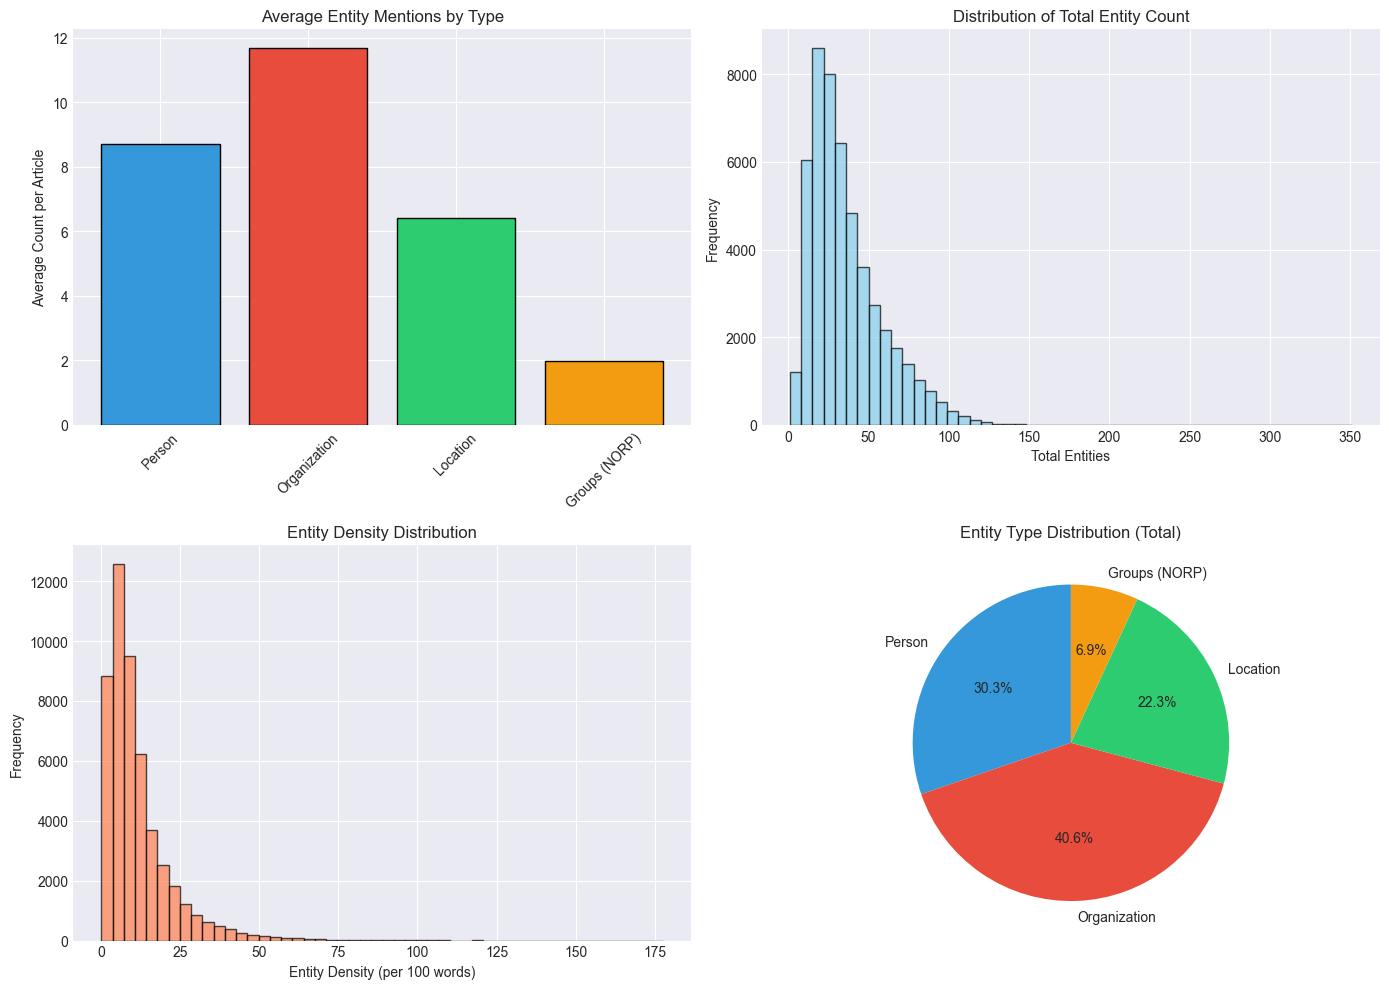

In [10]:
# Visualize entity counts
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Entity type distribution
entity_types = ['person_count', 'org_count', 'location_count', 'group_mention_count']
entity_labels = ['Person', 'Organization', 'Location', 'Groups (NORP)']
entity_means = [df[col].mean() for col in entity_types]

axes[0, 0].bar(entity_labels, entity_means, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'], edgecolor='black')
axes[0, 0].set_ylabel('Average Count per Article')
axes[0, 0].set_title('Average Entity Mentions by Type')
axes[0, 0].tick_params(axis='x', rotation=45)

# Total entities distribution
df[df['total_entities'] > 0]['total_entities'].hist(bins=50, ax=axes[0, 1],
                                                    edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 1].set_xlabel('Total Entities')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Total Entity Count')

# Entity density
df[df['entity_density'] > 0]['entity_density'].hist(bins=50, ax=axes[1, 0],
                                                    edgecolor='black', alpha=0.7, color='coral')
axes[1, 0].set_xlabel('Entity Density (per 100 words)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Entity Density Distribution')

# Entity type proportions
entity_totals = [df[col].sum() for col in entity_types]
axes[1, 1].pie(entity_totals, labels=entity_labels, autopct='%1.1f%%', startangle=90,
               colors=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
axes[1, 1].set_title('Entity Type Distribution (Total)')

plt.tight_layout()
plt.show()

#### Key Insights: Entity Usage in Articles

1) Articles are highly entity‑rich, typically containing dozens of named entities with most falling in a moderate entity‑density band (roughly 5–25 entities per 100 words).

2) Organizations and people dominate the entity landscape, together making up about 70% of all entities and having the highest average mentions per article, while groups (NORP) are referenced far less frequently.

 ## 4. Entity Diversity Analysis

In [11]:
print("\nAnalyzing entity diversity...")

# Unique entities per article
df['unique_persons'] = [len(set(e['PERSON'])) for e in entities_list]
df['unique_orgs'] = [len(set(e['ORG'])) for e in entities_list]
df['unique_locations'] = [len(set(e['GPE']) | set(e['LOC'])) for e in entities_list]

# Entity diversity (unique / total)
df['person_diversity'] = np.where(
    df['person_count'] > 0,
    df['unique_persons'] / df['person_count'],
    0
)

df['org_diversity'] = np.where(
    df['org_count'] > 0,
    df['unique_orgs'] / df['org_count'],
    0
)

df['location_diversity'] = np.where(
    df['location_count'] > 0,
    df['unique_locations'] / df['location_count'],
    0
)

print("Entity diversity calculated")


Analyzing entity diversity...
Entity diversity calculated


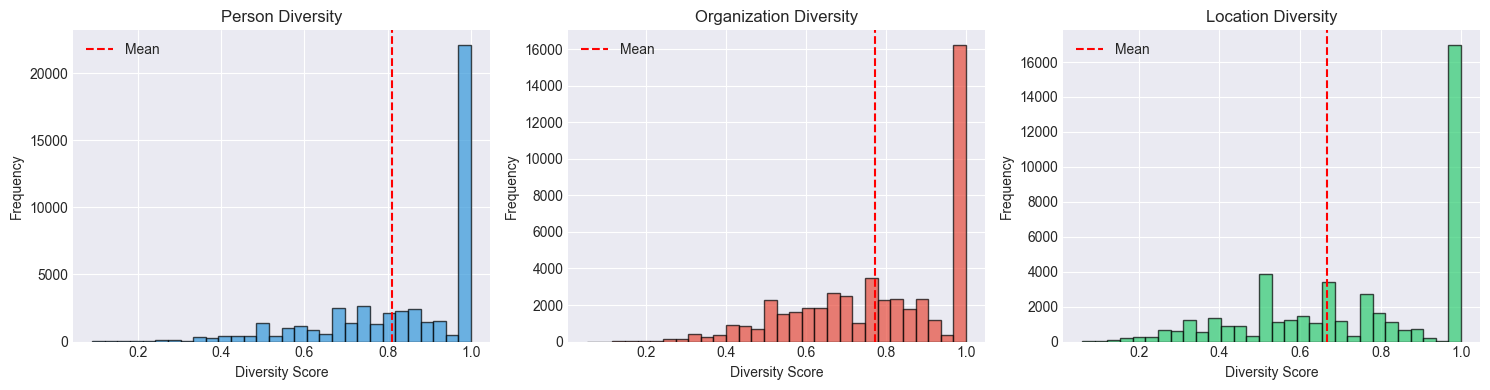

In [12]:
# Visualize diversity
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

diversity_cols = ['person_diversity', 'org_diversity', 'location_diversity']
diversity_labels = ['Person Diversity', 'Organization Diversity', 'Location Diversity']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, (col, label, color) in enumerate(zip(diversity_cols, diversity_labels, colors)):
    df[df[col] > 0][col].hist(bins=30, ax=axes[idx], edgecolor='black', alpha=0.7, color=color)
    axes[idx].set_xlabel('Diversity Score')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(label)
    axes[idx].axvline(df[col].mean(), color='red', linestyle='--', label='Mean')
    axes[idx].legend()

plt.tight_layout()
plt.show()

#### Key Insights: Entity Diversity (Persons, Orgs, Locations)

1) Most articles show high diversity in the entities they reference, with person and organization diversity scores clustering close to 1 and means around the upper end of the scale, indicating that many different people and organizations are typically mentioned rather than a few repeated ones.

2) Location diversity is slightly lower and more spread out, with a mean below that of persons/organizations and more articles with mid‑range scores, suggesting coverage leans on a somewhat narrower set of places compared to the broader mix of people and organizations.

 ## 5. Geographic Analysis

In [13]:
print("\nAnalyzing geographic patterns...")

# Extract all locations
all_locations = []
for entities in entities_list:
    all_locations.extend(entities['GPE'])
    all_locations.extend(entities['LOC'])

location_counter = Counter(all_locations)
top_locations = location_counter.most_common(20)

print(f"Found {len(location_counter)} unique locations")
print(f"\nTop 10 mentioned locations:")
for loc, count in top_locations[:10]:
    print(f"  {loc}: {count:,} mentions")


Analyzing geographic patterns...
Found 32346 unique locations

Top 10 mentioned locations:
  India: 38,617 mentions
  US: 12,595 mentions
  Pakistan: 10,110 mentions
  China: 5,861 mentions
  Delhi: 5,854 mentions
  Mumbai: 5,345 mentions
  Australia: 4,006 mentions
  Singh: 3,958 mentions
  England: 3,624 mentions
  Russia: 2,964 mentions


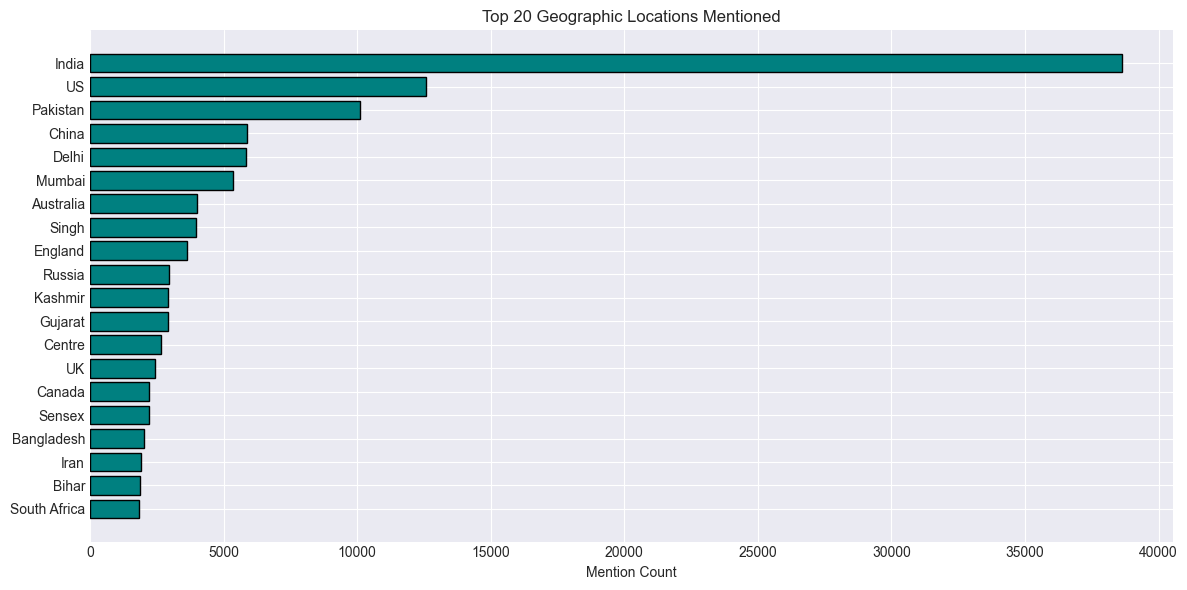

In [14]:
# Visualize top locations
if len(top_locations) > 0:
    locs, counts = zip(*top_locations)

    plt.figure(figsize=(12, 6))
    plt.barh(range(len(locs)), counts, color='teal', edgecolor='black')
    plt.yticks(range(len(locs)), locs)
    plt.xlabel('Mention Count')
    plt.title('Top 20 Geographic Locations Mentioned')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

#### Key Insights: Geographic Focus in Coverage

1) Coverage is overwhelmingly India‑centric, with India mentioned far more than any other location, and domestic hubs like Delhi, Mumbai, Gujarat, Kashmir, and Bihar also featuring prominently.

2) A small set of foreign countries dominate international references, led by the US, Pakistan, and China, while the remaining locations have much lower mention counts, indicating a relatively narrow international focus.

 ## 6. Organization Analysis

In [33]:
print("\nAnalyzing organizations...")

# Extract all organizations
all_orgs = []
for entities in entities_list:
    all_orgs.extend(entities['ORG'])

import csv

with open("all_orgs.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["organization"])
    for org in all_orgs:
        writer.writerow([org])

org_counter = Counter(all_orgs)
top_orgs = org_counter.most_common(1000)

with open("top_orgs.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["organization", "count"])
    for org, count in top_orgs:
        writer.writerow([org, count])
print ("Stored top organizations in top_orgs.csv")


Analyzing organizations...
Stored top organizations in top_orgs.csv


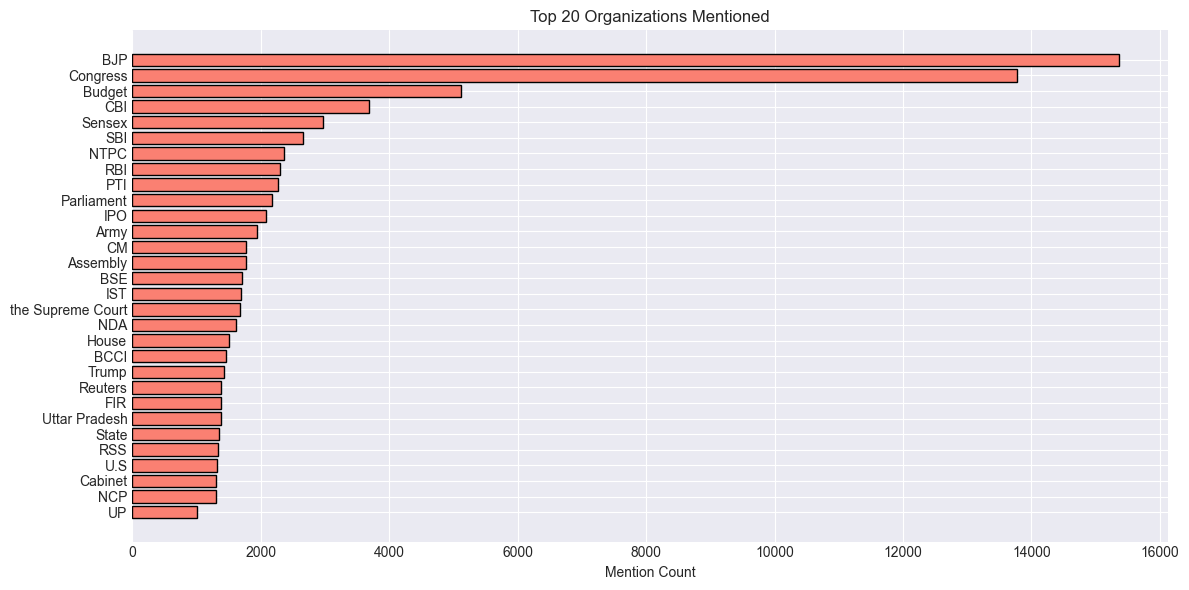

In [36]:
top_orgs_df = pd.read_csv("top_orgs.csv")
orgs = top_orgs_df["organization"].iloc[:30].tolist()
counts = top_orgs_df["count"].iloc[:30].tolist()

plt.figure(figsize=(12, 6))
plt.barh(range(len(orgs)), counts, color='salmon', edgecolor='black')
plt.yticks(range(len(orgs)), orgs)
plt.xlabel('Mention Count')
plt.title('Top 20 Organizations Mentioned')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Key Insights: Top Organizations Mentioned

1) National political parties dominate the coverage, with BJP and Congress far ahead of all other entities, indicating that party politics is a central focus of the news.

2) Government and economic institutions form the bulk of the remaining mentions – bodies like Budget, CBI, Sensex, SBI, RBI, Parliament, and Army appear frequently, while foreign or international actors (e.g., U.S, Trump, Reuters) are present but much less prominent.

 ## 7. Entity Co-occurrence with Bias Terms

In [37]:
print("\nAnalyzing entity co-occurrence with bias terms...")

# Bias keywords (simplified)
BIAS_KEYWORDS = {
    'gender': ['woman', 'women', 'man', 'men', 'female', 'male', 'gender'],
    'religion': ['hindu', 'muslim', 'christian', 'sikh', 'religious', 'religion'],
    'caste': ['caste', 'dalit', 'brahmin', 'sc', 'st', 'obc'],
    'political': ['bjp', 'congress', 'party', 'political', 'election']
}


def check_bias_cooccurrence(text, entities, bias_type):
    """Check if bias keywords appear near entities"""
    if not text or not entities:
        return 0

    text_lower = text.lower()
    keywords = BIAS_KEYWORDS.get(bias_type, [])

    count = 0
    for entity in entities:
        entity_lower = entity.lower()
        if entity_lower in text_lower:
            # Check if any bias keyword appears within 50 chars of entity
            for keyword in keywords:
                pattern = f'.{{0,50}}{re.escape(entity_lower)}.{{0,50}}{re.escape(keyword)}'
                if re.search(pattern, text_lower) or re.search(f'{re.escape(keyword)}.{{0,50}}{re.escape(entity_lower)}', text_lower):
                    count += 1
                    break

    return count


# Calculate co-occurrences
for bias_type in BIAS_KEYWORDS.keys():
    df[f'{bias_type}_entity_cooccurrence'] = [
        check_bias_cooccurrence(text, entities['PERSON'], bias_type)
        for text, entities in zip(df['text_for_analysis'], entities_list)
    ]

print("Bias-entity co-occurrence calculated")


Analyzing entity co-occurrence with bias terms...
Bias-entity co-occurrence calculated


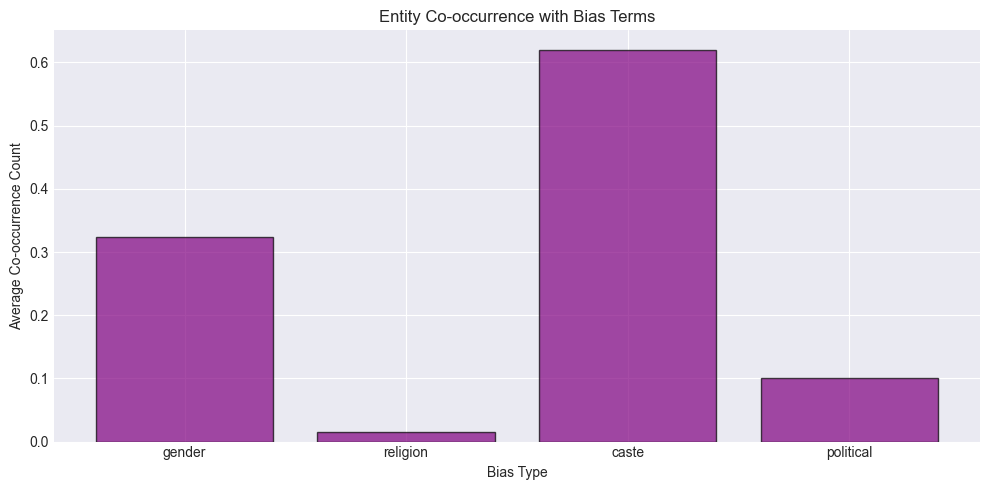

In [18]:
# Visualize co-occurrences
cooccur_cols = [f'{bias}_entity_cooccurrence' for bias in BIAS_KEYWORDS.keys()]
cooccur_means = [df[col].mean() for col in cooccur_cols]

plt.figure(figsize=(10, 5))
plt.bar(list(BIAS_KEYWORDS.keys()), cooccur_means, color='purple', edgecolor='black', alpha=0.7)
plt.xlabel('Bias Type')
plt.ylabel('Average Co-occurrence Count')
plt.title('Entity Co-occurrence with Bias Terms')
plt.tight_layout()
plt.show()

#### Key Insights: Entity Co-occurrence with Bias Terms

1) Caste-linked entities dominate co-occurrence with bias terms, showing the highest average co-occurrence, followed by gender. This suggests that when entities are mentioned alongside bias language, it is most often in caste and gender contexts.

2) Religion and political bias have much weaker entity co-occurrence, especially religion, indicating that explicit pairing of named entities with religious or political bias terms is comparatively rare in the corpus.

 ## 8. Feature Summary

In [19]:
# List all NER features
ner_features_list = [
    # Basic counts
    'person_count', 'org_count', 'location_count',
    'date_mention_count', 'money_mention_count',
    'group_mention_count', 'event_mention_count',
    'total_entities', 'entity_density',

    # Ratios
    'person_ratio', 'org_ratio', 'location_ratio',

    # Diversity
    'unique_persons', 'unique_orgs', 'unique_locations',
    'person_diversity', 'org_diversity', 'location_diversity',

    # Co-occurrence
    'gender_entity_cooccurrence', 'religion_entity_cooccurrence',
    'caste_entity_cooccurrence', 'political_entity_cooccurrence'
]

print(f"\n=== NER FEATURES SUMMARY ===")
print(f"Total NER features: {len(ner_features_list)}")
print(f"\nFeature categories:")
print(f"  - Basic entity counts: 8")
print(f"  - Entity ratios: 3")
print(f"  - Entity diversity: 6")
print(f"  - Bias co-occurrence: 4")


=== NER FEATURES SUMMARY ===
Total NER features: 22

Feature categories:
  - Basic entity counts: 8
  - Entity ratios: 3
  - Entity diversity: 6
  - Bias co-occurrence: 4


 ## 9. Save Features

In [20]:
# Select columns to save
columns_to_save = ['url'] + ner_features_list

df_ner = df[columns_to_save].copy()

print(f"\nSaving NER features...")
df_ner.to_parquet(OUTPUT_FILE, index=False, compression='snappy')

print(f"Saved to: {OUTPUT_FILE}")
print(f"  Size: {OUTPUT_FILE.stat().st_size / 1024**2:.2f} MB")
print(f"  Rows: {len(df_ner):,}")
print(f"  Features: {len(ner_features_list)}")


Saving NER features...
Saved to: ../data/processed/ner_features_sample.parquet
  Size: 3.80 MB
  Rows: 49,926
  Features: 22


 ## 10. Summary Report

INPUT: 49,926 articles
OUTPUT: 22 NER features

FEATURE BREAKDOWN:
  - Named entity recognition (8 entity types)
  - Entity density and ratios
  - Entity diversity metrics
  - Bias-entity co-occurrence analysis

KEY STATISTICS:
  - Articles with entities: 49,919 (100.0%)
  - Avg entities per article: 35.56
  - Avg entity density: 11.64 per 100 words
  - Unique persons mentioned: 339,523
  - Unique organizations: 401,820
  - Unique locations: 192,229

TOP ENTITIES:
  - Most mentioned location: India (38,617 times)
  - Most mentioned org: BJP (15,361 times)